# Clustering and association rule mining
## Part 1: Finding optimal hub locations
## 1. Business understanding
The goal of the analysis is to declare the optimal coordinates for the drone hubs using the customer locations.
## 2. Data understanding
The dataset has three columns
- clientid
- x
- y

Where x and y indicates customers' location coordinates
## 3. Data preparation
Visualizing the client locations in a two-dimensional scatterplot.

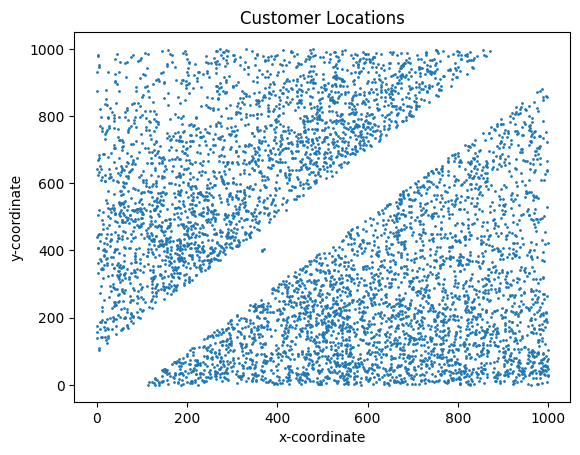

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/drone_cust_locations.csv', sep=';').drop('clientid', axis=1)

X = df['x']
y = df['y']

plt.scatter(X, y, s=1)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Customer Locations')
plt.show()


The scatterplot shows that the customer locations are divided by a diagonal gap. A geographical interpretation could be a large river.

## 4. Modelling
Calculating the optimal locations for three drone depots using K-means and agglomerative clustering.

In [16]:
from sklearn.cluster import KMeans

model = KMeans(init='random', n_clusters=3, random_state=42)
model.fit(df)

model.cluster_centers_

array([[702.08109226, 211.2703835 ],
       [198.44098904, 383.25861847],
       [548.20586479, 787.2788963 ]])

Below is the calculations for the optimal locations for ten drone depots using K-means clustering.

In [17]:
model = KMeans(init='random', n_clusters=10, random_state=42)
model.fit(df)

model.cluster_centers_

array([[881.10218422, 635.21820804],
       [452.0773205 , 767.46252873],
       [732.73746126, 401.79973121],
       [308.10079757,  87.32225671],
       [849.63070889, 128.41204786],
       [648.68575066, 895.59442536],
       [107.44746876, 365.00430943],
       [152.50728205, 799.99674306],
       [547.0171653 , 171.36638491],
       [250.11367099, 534.29876157]])

Creating an additional column that shows the nearest depot id for each customer location.

In [18]:
clusters = model.predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

df_with_clusters.head(10)

,x,y,depot
0,622.771572,164.857623,8
1,416.357298,630.193634,1
2,292.735020,567.333231,9
3,737.211288,166.225676,4
4,540.475375,682.912298,1
5,535.469492,318.439661,8
6,640.380050,870.833221,5
7,235.772075,359.048203,6
8,481.896884,661.491838,1
9,730.032789,312.177817,2


Visualizing the client locations with the optimal depot locations.

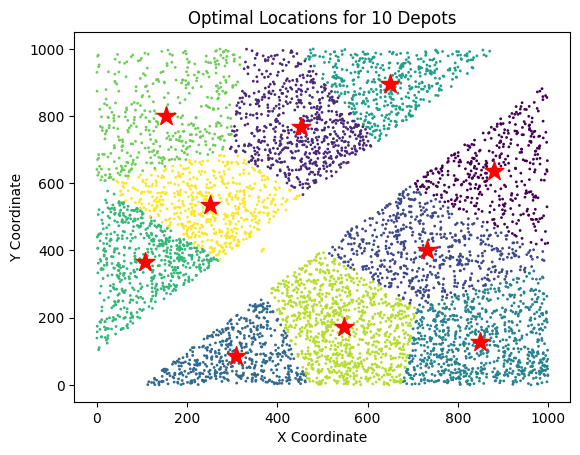

In [19]:
plt.scatter(df['x'], df['y'], c=model.labels_, s=1)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='red', marker='*', s=200)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Optimal Locations for 10 Depots')
plt.show()

### Setting depots with agglomerative clustering

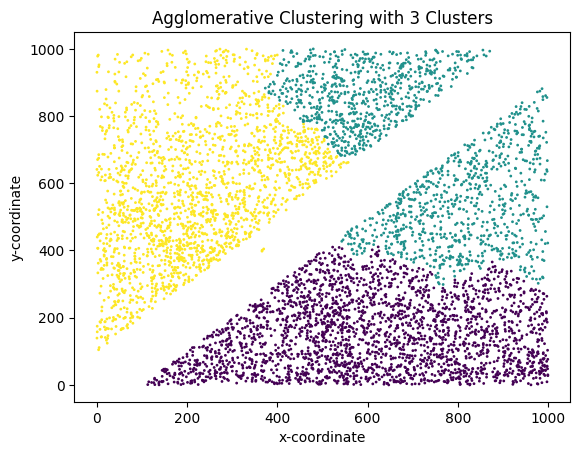

In [21]:
from sklearn.cluster import AgglomerativeClustering


model = AgglomerativeClustering(n_clusters=3)
clusters = model.fit_predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)
plt.title(f'Agglomerative Clustering with {3} Clusters')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.show()


Tested with higher number of clusters and ran into performance issues. Also, the borders of the clusters were not as clear as with K-means.

## 5. Evaluation
We used the elbow method with silhouette score analysis to provide an assessment of our clustering performance. In addition, we compared the computation time for ten and twenty depots.

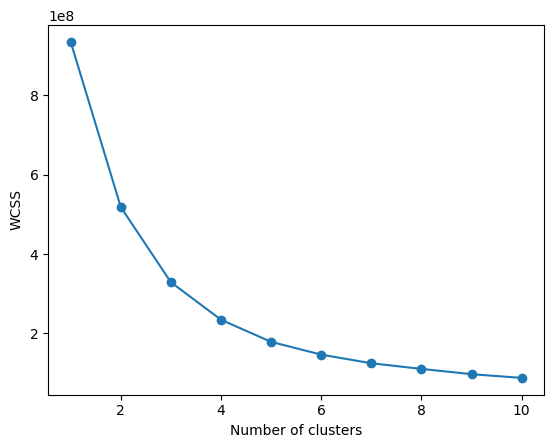

In [22]:
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(df)
    wcss.append(model.inertia_)

plt.plot(range(1, 11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The elbow method shows that the optimal number of clusters is 4. After 4, the decrease in inertia is not significant.

### Calculating the silhouette score

The silhouette score measures how well-defined our clusters are by evaluating both cluster cohesion and separation. Our score (0.366) indicates that our clusters are well-defined and distinct from each other.

In [23]:
from sklearn.metrics import silhouette_score

model = KMeans(init='random', n_clusters=10, random_state=42)

model.fit(df)

print(f'Silhouette score: {silhouette_score(df, model.labels_)}')

Silhouette score: 0.36632391559826993


### Calculating the runtime for 10 and 20 clusters

In [24]:
import time
# Measure runtime for 10 clusters
start_time_10 = time.time()
model_10 = KMeans(init='random', n_clusters=10, random_state=42)
model_10.fit(df)
end_time_10 = time.time()
runtime_10 = end_time_10 - start_time_10
print(f'Runtime for 10 clusters: {runtime_10} seconds')

# Measure runtime for 20 clusters
start_time_20 = time.time()
model_20 = KMeans(init='random', n_clusters=20, random_state=42)
model_20.fit(df)
end_time_20 = time.time()
runtime_20 = end_time_20 - start_time_20
print(f'Runtime for 20 clusters: {runtime_20} seconds')

Runtime for 10 clusters: 0.04387855529785156 seconds
Runtime for 20 clusters: 0.05485057830810547 seconds


We can see that the runtime almost doubles when the number of clusters is doubled.

## 6. Deployment
The models can be used to find out the optimal number of depots and their locations. The company can use this information to optimize their drone delivery routes and reduce delivery times. Because the customer locations are divided into two distinct groups, the number of depots should be paired. Each side of the gap should have the same number of depots.

## Part 2: Finding interesting relationships between product groups
## 1. Business Understanding
In this part, the task is to analyze the item sets and their correlations with others.
## 2. Data understanding
In this analysis, the dataset is a large list of sales data with 100,000 rows. There are two types of columns in the dataset:
- `ID` for the transaction ID
- `Prod1, ..., Prod20` indicates the one type of the product. In the rows these columns are marked with values 0 or 1 where 1 means that the one type of product has been purchased and 0 for not.
## 3. Data preparation
Reading the dataframe.


In [25]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

df = pd.read_csv('datasets/drone_prod_groups(1).csv', sep=',', dtype=int).drop('ID', axis=1)
df = df.replace({1: True, 0: False})
df

C:\Users\samul\AppData\Local\Temp\ipykernel_21772\2255544239.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({1: True, 0: False})


,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,Prod10,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,True,True
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True
3,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
99997,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False
99998,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True


## 4. Modelling
Applying the dataset into apriori.

In [26]:
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.10998,( Prod1)
1,0.13098,( Prod2)
2,0.10459,( Prod5)
3,0.13499,( Prod7)
4,0.16179,( Prod8)
5,0.19853,( Prod9)
6,0.10848,( Prod11)
7,0.15971,( Prod12)
8,0.14557,( Prod14)
9,0.11880,( Prod15)


This shows the most frequent items or item combinations with the highest support. For example Prod19 is the most frequently sold item with 0.20 support and the most frequent combination is Prod19 and Prod20.
## 5. Evaluation

In [27]:
# generate association rules

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# sort in descending order of confidence
rules = rules.sort_values(by='confidence', ascending=False)

rules = rules.drop(rules.columns[11:], axis=1)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric
1,( Prod15),( Prod9),0.11880,0.19853,0.11145,0.938131,4.725388,1.0,0.087865,12.954372,0.894663
3,( Prod20),( Prod19),0.14798,0.20626,0.13476,0.910664,4.415125,1.0,0.104238,8.884845,0.907849
2,( Prod19),( Prod20),0.20626,0.14798,0.13476,0.653350,4.415125,1.0,0.104238,2.457869,0.974508
0,( Prod9),( Prod15),0.19853,0.11880,0.11145,0.561376,4.725388,1.0,0.087865,2.009011,0.983664


Antecedent shows the item(s) that are bought and consequent shows the item(s) that are bought with the antecedent.

The data is sorted by confidence, meaning the probability of buying the consequent item given that the antecedent item is bought. For example:
- A customer who buys Prod15 will buy Prod9 with roughly a 94% probability.
- A customer who buys Prod20 will buy Prod19 with roughly a 91% probability.

## 6. Deployment
The association rules can be used to recommend products to customers based on their purchase history. For example, if a customer buys Prod15, the company can recommend Prod9 to them. Similarly, if a customer buys Prod20, the company can recommend Prod19 to them.